In [10]:
import bokeh

In [1]:
%pylab inline
import csv
import dask
from dask.distributed import Client
import seaborn as sns
import time

def sec_to_min_s(t):
    m = int(t/60)
    s = t%60
    return str(m)+":"+str(np.round(s, 2))

from dask_jobqueue import SLURMCluster

Populating the interactive namespace from numpy and matplotlib


In [2]:
run_local = False
n_workers_init = 6

if run_local:
    client = Client()
    client.cluster.scale(n_workers_init)
    time.sleep(0.5) # allow client time to respond to scaling before display
else:
    # note the specifed walltime, don't use too much or too little, 01:30:00 is a good baseline, 
    # you just need enough time to finish 'gathering' to props_all before the jobs die
    # you can always spin up more jobs later
    # you will launch many jobs, so you don't need multiple processes, a lot of ram or multiple threads
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',threads=1,processes=1,memory='6GB')
    
    #SHORT RUNS
#     cluster = SLURMCluster(queue="short",walltime='01:30:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster = SLURMCluster(queue="short",walltime='08:00:00',job_cpu=1,job_mem='6G',cores=1,processes=1,memory='6G')
    cluster.start_workers(n_workers_init)
    client = Client(cluster)

client

Client Scheduler: tcp://10.120.16.180:58245 Dashboard: http://10.120.16.180:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Ahora si pues!

In [2]:
# DEFINE DEFAULT VALUES
mTs = 3
mTa = 3
sTs = 0
sTa = 0

def growth_det(t, N0=1):
    '''
    Grow cells exponentially for a time t
        t: Growth time
        N0: Initial population
    '''
    return N0*np.exp(t)

def sample_Ts(mTs=mTs, sTs=sTs, size=1, use_cv = False):
    '''
    Sample lag times for the initial population according to a Gaussian distribution of lag times
        mTs: Mean lag time
        sTs: Standard deviation of lag times
        size: Initial population number
    '''
    if use_cv:
        return np.random.normal(loc=mTs, scale=sTs*mTs, size=size)
    else:
        return np.random.normal(loc=mTs, scale=sTs, size=size)

def sample_Ta(mTa=mTa, sTa=sTa, use_cv = False):
    '''
    Sample times of AB exposure for one round of growth according to a normal distribution
        mTa: Mean duration of AB
        sTs: Standard deviation of the duration of AB
    '''
    if use_cv:
        return np.random.normal(loc=mTa, scale=sTa*mTa)
    else:
        return np.random.normal(loc=mTa, scale=sTa)

def single_growth_cycle_stoch(Ts, ta, tg):
    '''
    Runs a single growth cycle for a given set of lag times Ts, a sampled AB duration ta,
    and a growth time tg
        Ts (array-like): List of lag times
        ta: antibiotic duration
        tg: growth time
    '''
    # select survivors i.e. cells for which Ts > Ta
    Ts_surv = Ts[np.where(Ts > ta)[0]]
    n_surv = len(Ts_surv)
    # select the cells that survived and started growing early enough to grow
    Ts_grow = Ts_surv[np.where(Ts_surv < ta+tg)[0]]
    n_grow = len(Ts_grow)
    # The ones that survived the AB but did not start growing only add 1 to the final count
    n_ngrow = n_surv - n_grow
    n = n_ngrow
    # Each parent cell contributes with a lineage that grows exponentially for a time tg-ts
    for ts in Ts_grow:
        n += growth_det(t=tg-ts)
    return n, n_surv, n_ngrow

def many_growth_cycles_stochTa_full(mTs, sTs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvss = False,
                                   use_cva = False):
    '''
    Run many growth cycles given the statistics for lag and AB times.
    At each cycle, lag times and AB times are sampled
    FULL_VERSION: Returns the entire array of final population
    '''
    N = np.zeros(k)
    N_surv = np.zeros(k)
    N_ngrow = np.zeros(k)
    for i in range(k):
        ta = sample_Ta(mTa=mTa, sTa=sTa, use_cv = use_cva)
        Ts = sample_Ts(mTs=mTs, sTs=sTs, size=n0, use_cv=use_cvs)
        N[i], N_surv[i], N_ngrow[i] = single_growth_cycle_stoch(Ts=Ts, ta=ta, tg=tg)
    return N, N_surv, N_ngrow

def many_growth_cycles_stochTa_short(mTs, sTs=0.5, mTa=3, sTa=0, k=1000, n0=100, tg=8, use_cvs = False,
                                    use_cva = False):
    '''
    Run many growth cycles given the statistics for lag and AB times.
    At each cycle, lag times and AB times are sampled
    SHORT_VERSION: Returns the means and variances of the final population
    '''
    n_sum, n_surv_sum, n_ngrow_sum = 0, 0, 0
    n2_sum, n_surv2_sum, n_ngrow2_sum = 0, 0, 0
    
    for _ in range(k):
        ta = sample_Ta(mTa=mTa, sTa=sTa, use_cv=use_cva)
        Ts = sample_Ts(mTs=mTs, sTs=sTs, size=n0, use_cv = use_cvs)
        n, n_surv, n_ngrow = single_growth_cycle_stoch(Ts=Ts, ta=ta, tg=tg)
        
        n_sum, n_surv_sum, N_grow_sum = n_sum+n, n_surv_sum+n_surv, n_ngrow_sum+n_ngrow
        n2_sum, n_surv2_sum, n_ngrow2_sum = n2_sum+n**2, n_surv2_sum+n_surv**2, n_ngrow2_sum+n_ngrow**2
            
    mN, mN_surv, mN_ngrow = n_sum/k, n_surv_sum/k, n_ngrow_sum/k
    vN, vN_surv, vN_ngrow = n2_sum/k-mN**2, n_surv2_sum/k-mN_surv**2, n_ngrow2_sum/k-mN_ngrow**2
    return mN, mN_surv, mN_ngrow, vN, vN_surv, vN_ngrow

def sample_Ts_statistics(MTs, STs=[0.5], mTa=3, sTa=0, k=1000, n0=100, tg=8, use_cvs = False, use_cva=False):
    '''
    Run many growth cycles FOR DIFFERENT VALUES OF THE
    STATISTICS FOR THE LAG TIMES. 
    SHORT_VERSION: Returns the entire array of final population
    '''
    # TODO: Initialize arrays to store what you want
    MN = np.zeros((len(MTs), len(STs)))
    VN = np.zeros((len(MTs), len(STs)))
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            # TODO: Modify to keep what you want
            mN, _, _, vN, _, _ = many_growth_cycles_stochTa_short(mTs=mTs, sTs=sTs, mTa=mTa,
                                                                  sTa=sTa, k=k, n0=n0, tg=tg,
                                                                 use_cvs=use_cvs, use_cva=use_cva)
            MN[i,j] = mN
            VN[i,j] = vN
    return MN, VN

def sample_Ts_long(MTs, STs, mTa, sTa, k=1000, n0=1000, tg=3, use_cvs=False, use_cva=False):
    '''
    Run many growth cycles FOR DIFFERENT VALUES OF THE
    STATISTICS FOR THE LAG TIMES.
    LONG_VERSION: Returns the entire array of final population
    Returns:
        
    '''
    # TODO: Initialize arrays to store what you want
    NN, N_SURV, N_NGROW = np.zeros((len(MTs), len(STs), k)), np.zeros((len(MTs), len(STs), k)), np.zeros((len(MTs), len(STs), k))
    for i in range(len(MTs)):
        mTs = MTs[i]
        for j in range(len(STs)):
            sTs = STs[j]
            # TODO: Modify to keep what you want
            N, N_surv, N_ngrow = many_growth_cycles_stochTa_full(mTs=mTs, sTs=sTs, mTa=mTa,
                                                                  sTa=sTa, k=k, n0=n0, tg=tg,
                                                                use_cvs=use_cvs, use_cva=use_cva) 
            NN[i,j,:] = N
            N_SURV[i,j,:] = N_surv
            N_NGROW[i,j,:] = N_ngrow
            
    return NN, N_SURV, N_NGROW

def save_experiment(exp_key, res, kwargs, kwargs_s):

    # Save MTs and STs
    np.save('./exp_'+exp_key, res)
    # Save metadata (parameters)
    file = open('./exp_'+exp_key+'_meta.csv', "w")
    w = csv.writer(file)
    for key, val in kwargs.items():
        w.writerow([key, val])
    for key, val in kwargs_s.items():
        w.writerow([key, val])
    file.close()


In [4]:
MTs_start = 1
MTs_stop = 8
MTs_step = 0.05

STs_start = 0
STs_stop = 2
STs_step = 0.05

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start,'STs_stop':STs_stop,'STs_step':STs_step}

MTs = np.arange(MTs_start,MTs_stop,MTs_step)
STs = np.arange(STs_start,STs_stop,STs_step)

mTa = 3
sTa = 0.5
k = 100000
n0 = 1000
tg = 8
# many_growth_cycles_stochTa_short(mTs, sTs=0.5, mTa=3, sTa=0, k=1000, n0=100, tg=8, use_cvs = False,
          #                          use_cva = False)
    
kwargs = {'mTa':mTa, 'sTa':sTa, 'k':k, 'n0':n0, 'tg':tg}

scale_workers = 50
if scale_workers > 0:
    cluster.scale(scale_workers)
futures = []
for sTs in STs:
    def PAR_many_growth_cycles_stochTa_short(mTs):
        return many_growth_cycles_stochTa_short(mTs, sTs, **kwargs)
    fut = client.map(PAR_many_growth_cycles_stochTa_short, MTs)
    futures.append(fut) 
all_futures = [fu for sublist in futures for fu in sublist]
dask.distributed.progress(all_futures)

VBox()

In [5]:
res = np.array(client.gather(futures))

In [6]:
exp_key = '010' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

Text(0.5, 1.0, '$t_a=$3')

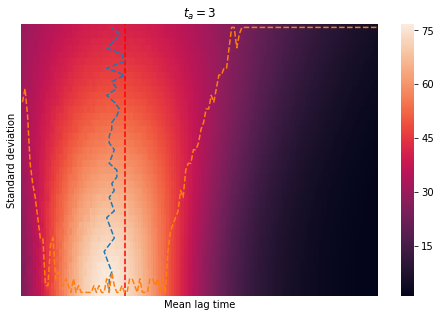

In [7]:
MN = res[:,:,0].T
VN = res[:,:,3].T

#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

plt.figure(figsize=(8,5))
y_conv = np.arange(len(max_MTs_vs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '--')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '--')
# ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
ax = sns.heatmap(MN.T/n0, yticklabels=False, xticklabels=False)
plt.vlines(np.where(abs(MTs-3) <= 0.05/2)[0][0]+0.5, 0,len(y_conv), color='r', linestyles='--')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

In [ ]:
MTs_start = 1
MTs_stop = 8
MTs_step = 0.05

STs_start = 0
STs_stop = 2
STs_step = 0.05

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start,'STs_stop':STs_stop,'STs_step':STs_step}

MTs = np.arange(MTs_start,MTs_stop,MTs_step)
STs = np.arange(STs_start,STs_stop,STs_step)

mTa = 3
sTa = 3
k = 100000
n0 = 1000
tg = 8
# many_growth_cycles_stochTa_short(mTs, sTs=0.5, mTa=3, sTa=0, k=1000, n0=100, tg=8, use_cvs = False,
          #                          use_cva = False)
    
kwargs = {'mTa':mTa, 'sTa':sTa, 'k':k, 'n0':n0, 'tg':tg}

scale_workers = 100
if scale_workers > 0:
    cluster.scale(scale_workers)
futures = []
for sTs in STs:
    def PAR_many_growth_cycles_stochTa_short(mTs):
        return many_growth_cycles_stochTa_short(mTs, sTs, **kwargs)
    fut = client.map(PAR_many_growth_cycles_stochTa_short, MTs)
    futures.append(fut) 
all_futures = [fu for sublist in futures for fu in sublist]
dask.distributed.progress(all_futures)

res = np.array(client.gather(futures))

exp_key = '009' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

In [ ]:
MTs_start = 1
MTs_stop = 8
MTs_step = 0.05

STs_start = 0
STs_stop = 2
STs_step = 0.05

kwargs_s = {'MTs_start':MTs_start, 'MTs_stop':MTs_stop, 'MTs_step':MTs_step,
            'STs_start':STs_start,'STs_stop':STs_stop,'STs_step':STs_step}

MTs = np.arange(MTs_start,MTs_stop,MTs_step)
STs = np.arange(STs_start,STs_stop,STs_step)

mTa = 3
sTa = 4
k = 100000
n0 = 1000
tg = 8
# many_growth_cycles_stochTa_short(mTs, sTs=0.5, mTa=3, sTa=0, k=1000, n0=100, tg=8, use_cvs = False,
          #                          use_cva = False)
    
kwargs = {'mTa':mTa, 'sTa':sTa, 'k':k, 'n0':n0, 'tg':tg}

scale_workers = 100
if scale_workers > 0:
    cluster.scale(scale_workers)
futures = []
for sTs in STs:
    def PAR_many_growth_cycles_stochTa_short(mTs):
        return many_growth_cycles_stochTa_short(mTs, sTs, **kwargs)
    fut = client.map(PAR_many_growth_cycles_stochTa_short, MTs)
    futures.append(fut) 
all_futures = [fu for sublist in futures for fu in sublist]
dask.distributed.progress(all_futures)

res = np.array(client.gather(futures))

exp_key = '010' # MODIFY SO YOU DON'T OVERWRITE!!!!!
save_experiment(exp_key, res, kwargs, kwargs_s)

Text(0.5, 1.0, '$t_a=$3')

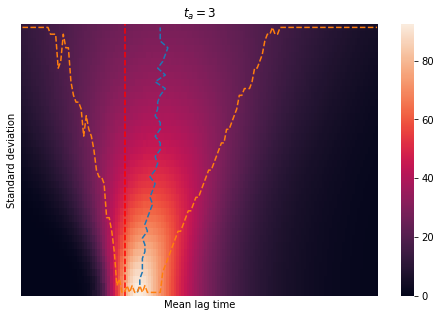

In [7]:
MN = res[:,:,0].T
VN = res[:,:,3].T

#Indices of E(T_s) values for max fitness as a function of std
max_MTs_vs_std = np.argmax(MN, axis=0)
#Indices of std(T_s) values for max fitness as a function of E(T_s)
max_STs_vs_mean = np.argmax(MN, axis=1)

plt.figure(figsize=(8,5))
y_conv = np.arange(len(max_MTs_vs_std))
plt.plot(max_MTs_vs_std+0.5, y_conv+0.5, '--')
x_conv = np.arange(len(max_STs_vs_mean))
plt.plot(x_conv+0.5, max_STs_vs_mean+0.5, '--')
# ax = sns.heatmap(MN.T/n0, yticklabels=STs, xticklabels=MTs)
ax = sns.heatmap(MN.T/n0, yticklabels=False, xticklabels=False)
plt.vlines(np.where(abs(MTs-3) <= 0.05/2)[0][0]+0.5, 0,len(y_conv), color='r', linestyles='--')
ax.invert_yaxis()
plt.ylabel('Standard deviation')
plt.xlabel('Mean lag time')
plt.title('$t_a=$'+str(mTa))

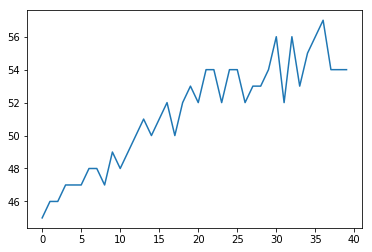

In [8]:
plt.plot(max_MTs_vs_std)

In [10]:
MTs[max_MTs_vs_std[0]]

3.2500000000000018

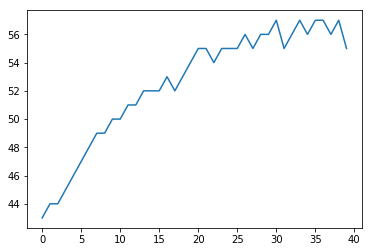

In [26]:
plt.plot(max_MTs_vs_std)

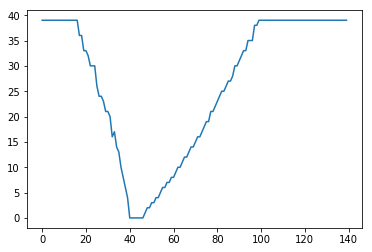

In [28]:
plt.plot(max_STs_vs_mean)

In [31]:
np.argmin(max_STs_vs_mean)

40

In [34]:
max_STs_vs_mean[40]

0

### 2019/03/31

For fixed mTa and sTa
I need to screen mainly across MTs and STs. (Then test for several values of sTa).
The number of simulations $k$ needed for a certain value of sTa will grow as sTa. It will be huge if I want to get a good estimate of the means (TODO estimate this).
In each simulation, I want to store the statistics for all N_f, N_ngrow, N_surv (maybe the total for one, but it will be a lot of data if I do it for all simulations).
I want to check different values of t_g too, but maybe just for some of them.
Maybe: Test different n0, increasing n0 is also a way to reduce the noise in N_f. However, simulations will take longer to run.